# Relax Takehome Feature Analysis

Table of Contents
1. Intro
2. Methodology
3. Results
4. Further Research 
Run linear regression on the feature set
Engineer more complicated features like rate of adopted users or usage rate in associated orgs. 

### Intro

In order to see how we can increase user adoption rate of the product, we must first make an analysis of the product itself to understand how everything works. A good place to start is to analyze the users that are already adopted and see what features are common between them. Once we have the important features, we can use them to learn how they affected the adopted users habits, and give us insight on what kinds of methods we can employ to increase overall user adoption. 

### Methodology and Process

With the two provided datasets we are able to determine which users are adopted based on a standard metric using the takehome_user_engagement table, and then label the appropriate user profiles in the takehome_users table. The metric provided is any user that has used the system 3 times in a week's span. 

I then plan to build a classifier using a Random Forest Algorithm. With that algorithm we can extract the feature importances from the model to see what features adopted users are more likely to have.

In [63]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import matplotlib.pyplot as plt

import math

This code is to read in the user engagement table, sort by the timestamp, and set th index to a timestamp.

In [88]:
# read the csv file
engagement_df = pd.read_csv('./takehome_user_engagement.csv').sort_values(by=['user_id', 'time_stamp'], ascending=True).reset_index(drop=True)

# set convert timestamp to date time data, and set as index
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])
engagement_df.index = engagement_df['time_stamp']
engagement_df.head(10)

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1
2013-12-31 03:45:04,2013-12-31 03:45:04,2,1
2014-01-08 03:45:04,2014-01-08 03:45:04,2,1
2014-02-03 03:45:04,2014-02-03 03:45:04,2,1
2014-02-08 03:45:04,2014-02-08 03:45:04,2,1


This code aggregates the timestamps by week and user. It when filters out the users that have not at least had one week with 3 days of use.

In [93]:
# group dataframe by user id and timestamp
agg_week = engagement_df.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W')]).sum()

# filter out users that don't at least have one week with 3 visits
adopted_user_visits = agg_week[agg_week.visited >= 3]
adopted_user_visits.head(10)

visited
user_id time_stamp         
2       2014-02-09        3
10      2013-03-03        3
        2013-04-14        3
        2013-04-28        3
        2013-05-05        4
        2013-05-12        5
        2013-05-19        3
        2013-06-09        4
        2013-06-16        5
        2013-06-23        3

We can then get a list of unique users from the table above and use them to apply labels to the other dataset.

In [49]:
# get unique ids from dataframe and get a count
adopted_user_ids = pd.Series(adopted_user_visits.index.get_level_values(level='user_id').values).unique()
adopted_user_ids_count = len(adopted_user_ids)

print("There are {} adopted users.".format(len(adopted_user_ids)))

There are 1445 adopted users.


This code loads up the second dataset with user profiles. Using the user id's from the other data set, we can label which users are adopted and which ones are not.

In [100]:
user_df = pd.read_csv('./takehome_users.csv')
user_df['adopted'] = user_df['object_id'].apply(lambda x: True if x in adopted_user_ids else False)
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


To clean up the features, we can remove features that most likely will not have an affect on which users become adopted. The features we will remove are email address, name, creation time, when the user last logged out. 

We also are removing organization id because as a lone feature it is not that useful. There are likely to be many organization ids, causing two problems. We can't use that feature as it is because if we did the model would view it as a hierarchal feature, and if we one hot encode the feature that will create too many features.

If given more time, we could do some feature engineering using it like getting statistics of the organization a user belongs to and apply it to their profile. Statistics can include adopted user percentages in the org, or how many usage levels.

The same logic goes for invited user.

In [101]:
# drop features to clean up dataset
user_df2 = user_df.drop(['email','creation_time','name','last_session_creation_time', 'org_id', 'invited_by_user_id'], axis=1)
user_df2.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted
0,1,GUEST_INVITE,1,0,False
1,2,ORG_INVITE,0,0,True
2,3,ORG_INVITE,0,0,False
3,4,GUEST_INVITE,0,0,False
4,5,GUEST_INVITE,0,0,False


Since creation source only has 5 different values we can one hot encode them without affecting the dataset too much, and it allows us to get 5 features from a single feature.

In [102]:
# one hot encode creation_source feature
user_df2 = pd.get_dummies(user_df2, prefix_sep = '_', columns=['creation_source'])
user_df2.head(5)

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,False,1,0,0,0,0
1,2,0,0,True,0,1,0,0,0
2,3,0,0,False,0,1,0,0,0
3,4,0,0,False,1,0,0,0,0
4,5,0,0,False,1,0,0,0,0


Split the data into training and test sets. We are using the adopted feature we created from the other dataset.

Using the split datasets we can define, train, and score the random tree classifier.

In [105]:
# split the datset
X_train, X_test, y_train, y_test = train_test_split(user_df2.loc[:, user_df2.columns != 'adopted'], user_df2['adopted'],
                                                    test_size=.25,
                                                    random_state=42)

# define, train, and score the model
clf = RandomForestClassifier(max_depth=2)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

print("The model is scoring at {:.2f}%".format(score * 100))

The model is scoring at 87.83%


C:\Users\JR\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Results

With a decently high percentage score we can graph out the feature importances of the model and see which are contirbuting the most to the models decicsion in classifying a user as adopted. 

If the model puts a lot of weight into the feature, that means it is a statistically significant feature to the the user being "adopted".

The graph below plots the features in order of siginicance, highest to lowest. With the top 3 feature's being the source of creation for the user.

Feature ranking:
1. creation_source_SIGNUP_GOOGLE_AUTH (0.270594)
2. creation_source_SIGNUP (0.225804)
3. creation_source_PERSONAL_PROJECTS (0.155626)
4. creation_source_ORG_INVITE (0.148437)
5. creation_source_GUEST_INVITE (0.132261)
6. enabled_for_marketing_drip (0.039713)
7. opted_in_to_mailing_list (0.014705)
8. object_id (0.012860)


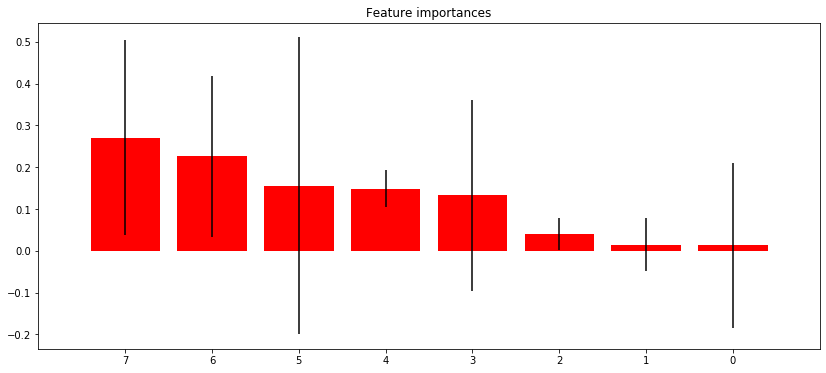

In [106]:
# Your code here
importances = np.sort(clf.feature_importances_)
std = np.std([clf.feature_importances_ for clf in clf.estimators_], axis = 0)
indices = np.argsort(importances[::-1])

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(14,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Further Research 

If given more time futher analysis could be made on the dataset. A few things that came to mind while working through the dataset are the following.

1. Running linear regression on the dataset - If we run linear regression on the model to predict the amount of time a user will login to the website. From that model we can find the statistical significances of each feature and compare the rankings with this random tree classifier.
2. More complicated feature engineering - We can engineer more features using the organizations or users that invited the user and build statistics around their usage stats and profile.